## Overview

In this notebook, will investigate the internal process of YOLO to get deeper understanding of them.

We will try to answer the followng questions:

- How feature maps and anchors actually looks like?
- What feature maps YOLO mostly relies on?

Can also showcases how to change default behavior of YOLO using a simple snippet.

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [2]:
from ultralytics import YOLO


model = YOLO("/kaggle/input/train-yolo/yolo_weights/motor_detector/weights/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from ultralytics.nn.tasks import DetectionModel

DetectionModel(cfg="yolov8n.yaml", ch=3, nc=1)
pass

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Seeing the output of last layer (index 22), it shows `[15, 18, 21]` in the second column. 
These are the indices of the input layers.
The output of these layers are called **anchors**.
These are the feature maps with different resolutions.

As we can see later, `yolov8n` model uses `[1/8, 1/16, 1/32]` resolution of feature maps as the inputs.

## Visualize Input Image

In [4]:
import polars as pl

label_df = pl.read_csv("/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train_labels.csv")
label_df = label_df.filter(pl.col("Number of motors") > 0)
label_df.head(1)

shape: (1, 10)
┌────────┬──────────────┬────────┬────────┬───┬──────────────┬─────────────┬─────────┬─────────────┐
│ row_id ┆ tomo_id      ┆ Motor  ┆ Motor  ┆ … ┆ Array shape  ┆ Array shape ┆ Voxel   ┆ Number of   │
│ ---    ┆ ---          ┆ axis 0 ┆ axis 1 ┆   ┆ (axis 1)     ┆ (axis 2)    ┆ spacing ┆ motors      │
│ i64    ┆ str          ┆ ---    ┆ ---    ┆   ┆ ---          ┆ ---         ┆ ---     ┆ ---         │
│        ┆              ┆ f64    ┆ f64    ┆   ┆ i64          ┆ i64         ┆ f64     ┆ i64         │
╞════════╪══════════════╪════════╪════════╪═══╪══════════════╪═════════════╪═════════╪═════════════╡
│ 1      ┆ tomo_00e047  ┆ 169.0  ┆ 546.0  ┆ … ┆ 959          ┆ 928         ┆ 15.6    ┆ 1           │
└────────┴──────────────┴────────┴────────┴───┴──────────────┴─────────────┴─────────┴─────────────┘

In [5]:
row = label_df.to_dicts()[0]
tomo_id = row["tomo_id"]
z0 = int(row["Motor axis 0"])
y0 = row["Motor axis 1"]
x0 = row["Motor axis 2"]
image_path = (
    f"/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/train/{tomo_id}/slice_{z0:04d}.jpg"
)

In [6]:
model.predictor = model._smart_load("predictor")(overrides=dict(imgsz=960), _callbacks=model.callbacks)
model.predictor.setup_model(model=model.model, verbose=True)

Ultralytics 8.3.139 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


In [7]:
predictor = model.predictor
predictor.setup_source(image_path)

(959, 928, 3)
(960, 960, 3)


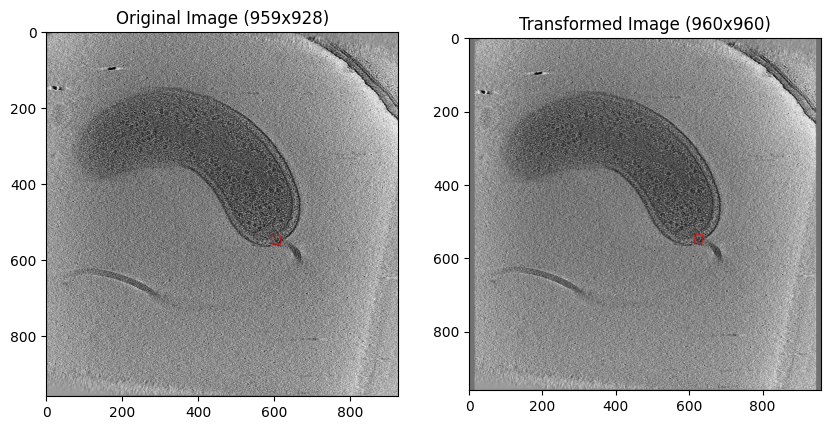

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

for predictor.batch in predictor.dataset:
    original_img = model.predictor.batch[1][0]
    transformed_img = (
        model.predictor.preprocess(original_img[None, ...])
        .squeeze(0)
        .permute(1, 2, 0)
        .detach()
        .cpu()
        .numpy()
    )
    print(original_img.shape)
    print(transformed_img.shape)
    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax = axes[0]
    ax.imshow(original_img, cmap="gray")
    H0, W0, _ = original_img.shape
    ax.set_title(f"Original Image ({H0}x{W0})")
    s = 24
    ax.add_patch(
        Rectangle(
            (x0 - s / 2, y0 - s / 2),
            s,
            s,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
            alpha=0.5,
        )
    )
    
    ax = axes[1]
    ax.imshow(transformed_img, cmap="gray")
    H, W, _ = transformed_img.shape
    ax.set_title(f"Transformed Image ({H}x{W})")
    x = (x0 + 0.5) * W / W0 - 0.5
    y = (y0 + 0.5) * H / H0 - 0.5
    s = 24
    ax.add_patch(
        Rectangle(
            (x - s / 2, y - s / 2),
            s,
            s,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
            alpha=0.5,
        )
    )
    plt.show()

The above pictures shows the before and after preprocessing input tomogram slice.
They seems almost the same, but the resolution is adjusted to (960, 960), and we can also see they are padded in the shorter edges (the transform is called `Letterbox` transform which is the default preprocess of YOLO models).

## Visualize Feature Maps

Since YOLO does not support visualizing feature maps, we should use some tricks to change YOLO's default behaviour.

We can use the below snippet to dynamically replace the method of existing objects.
The below snippets will change the default behaviour of detection model **to output entire feature maps** (instead of just pooled embeddings).

In [9]:
from typing import Callable


def replace_method(obj, method_name: str, func: Callable):
    """
    Replace a method of an object with a new function.

    Args:
        obj: The object whose method is to be replaced.
        method_name (str): The name of the method to replace.
        func (FunctionType): The new function to set as the method.
    """
    if not hasattr(obj, method_name):
        raise AttributeError(
            f"{obj.__class__.__name__} has no method '{method_name}' to replace."
        )
    bound = func.__get__(obj, obj.__class__)
    setattr(obj, method_name, bound)

In [10]:
def _predict_once(self, x, profile=False, visualize=False, embed=None):
    """
    MODIFICATION:
        - return entire feature map instead of pooled embedding when embed specified

    License: AGPL-3.0
    Source:
        - https://github.com/ultralytics/ultralytics
    """
    print("new predict once")
    y, dt, embeddings = [], [], []  # outputs
    for m in self.model:
        if m.f != -1:  # if not from previous layer
            x = (
                y[m.f]
                if isinstance(m.f, int)
                else [x if j == -1 else y[j] for j in m.f]
            )  # from earlier layers
        if profile:
            self._profile_one_layer(m, x, dt)
        x = m(x)  # run
        y.append(x if m.i in self.save else None)  # save output
        if embed and m.i in embed:
            embeddings.append(x.detach())
            if m.i == max(embed):
                return embeddings
    return x


replace_method(model.model, "_predict_once", _predict_once)

Now we get prepared, let's process the sample image to get their feature maps.

In [11]:
embeddings = model(image_path, conf=0.005, imgsz=960, verbose=False, embed=[15, 18, 21])

new predict once


In [12]:
for i, emb in enumerate(embeddings):
    print(i, emb.shape)

0 torch.Size([1, 64, 120, 120])
1 torch.Size([1, 128, 60, 60])
2 torch.Size([1, 256, 30, 30])


## Visualize Feature Maps

The below images are first 5 dimensions of each feature maps.
We can roughly see they capture some features in the input slice.

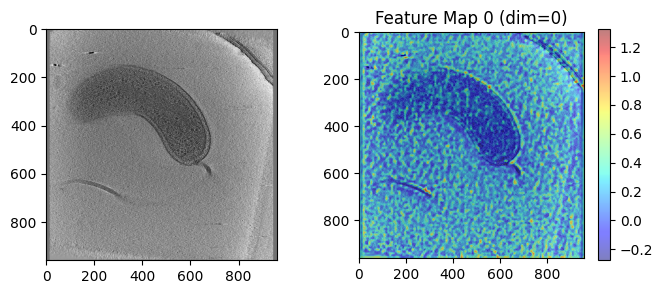

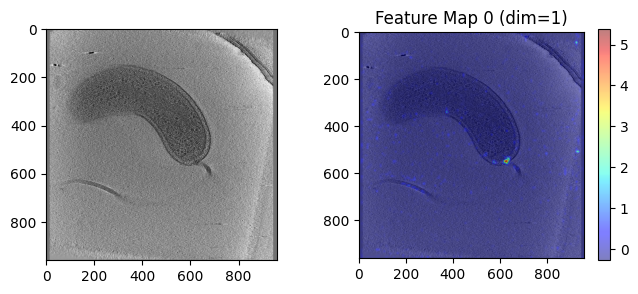

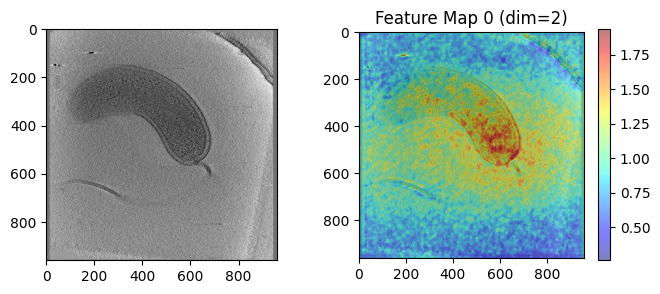

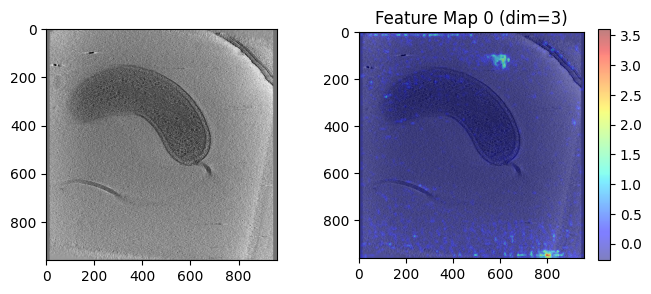

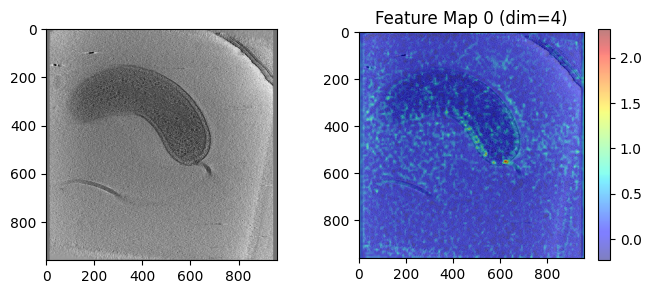

--------------------------------------------------------------------------------


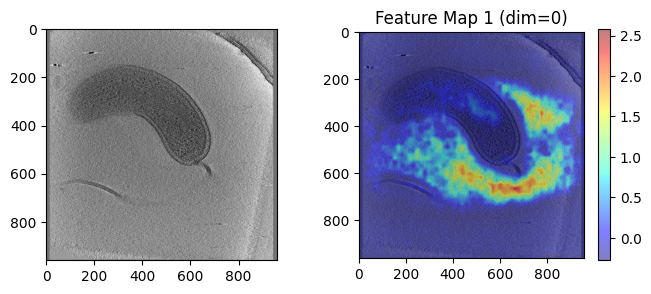

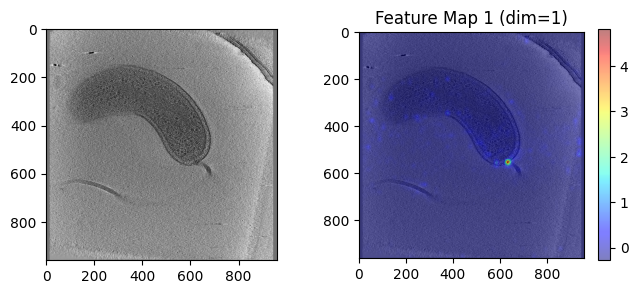

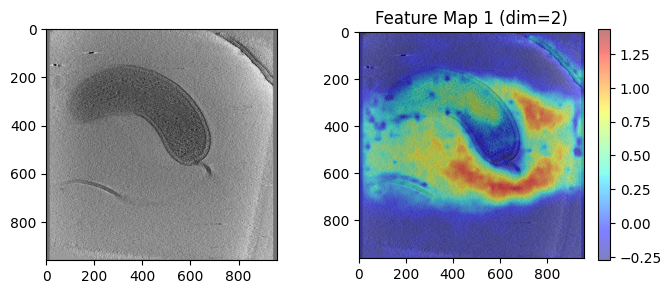

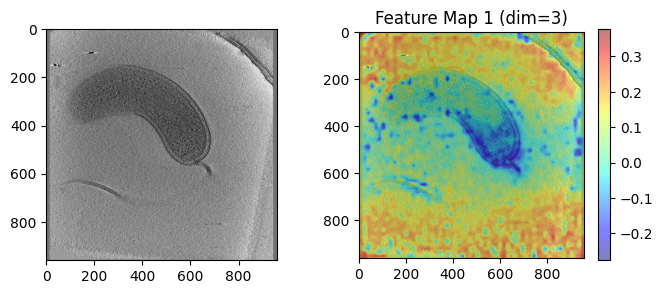

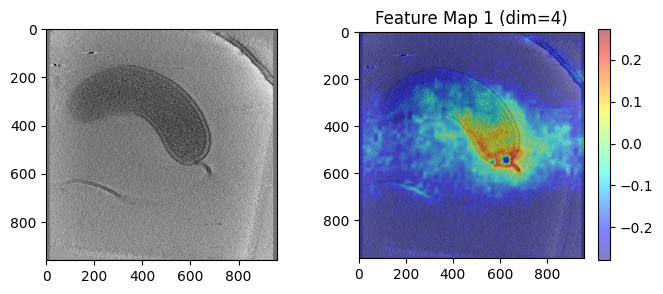

--------------------------------------------------------------------------------


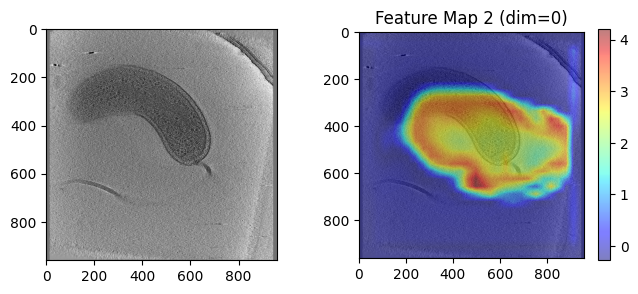

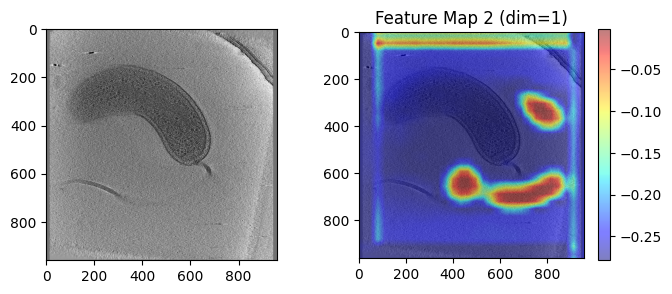

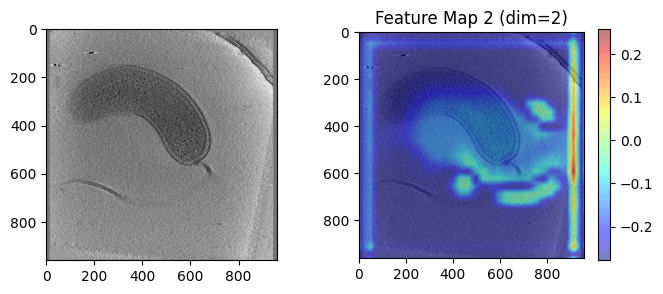

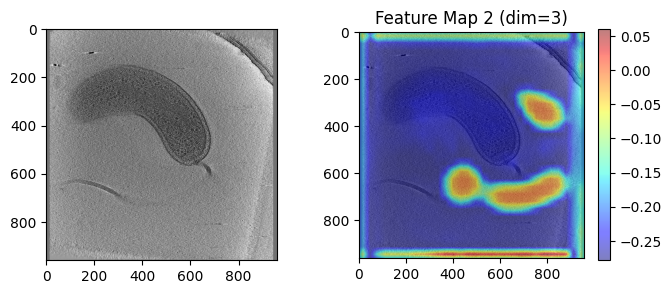

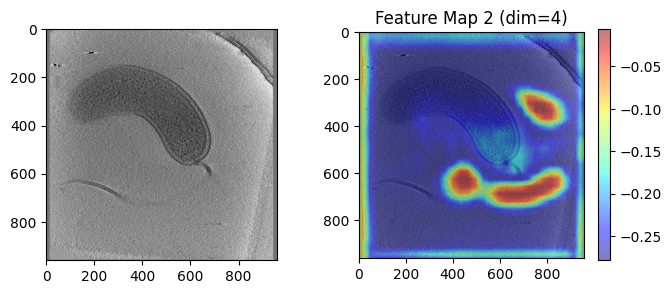

--------------------------------------------------------------------------------


In [13]:
import numpy as np
from skimage.transform import resize

for j, emb in enumerate(embeddings):
    for i, fmap in enumerate(emb[0, :5]):
        _, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
        ax0.imshow(transformed_img, extent=(0, transformed_img.shape[1], transformed_img.shape[0], 0))
    
        resized_fmap = resize(
            fmap, (transformed_img.shape[0], transformed_img.shape[1]), anti_aliasing=True
        )
        ax1.imshow(transformed_img, extent=(0, transformed_img.shape[1], transformed_img.shape[0], 0))
        g = ax1.imshow(resized_fmap, cmap="jet", alpha=0.5, extent=(0, transformed_img.shape[1], transformed_img.shape[0], 0))
        ax1.set_title(f"Feature Map {j} (dim={i})")
        plt.colorbar(g, ax=ax1)
        plt.show()
    print("-" * 80)

## Visualize Anchors

In [14]:
def calc_num_anchors(embedding):
    _, _, h, w = embedding.shape
    return h * w

anchor_sizes = []
total_anchors = 0
for i, emb in enumerate(embeddings):
    num_anchors = calc_num_anchors(emb)
    print(f"Embedding {i}: {emb.shape}")
    print(f"#anchors: {num_anchors}")
    total_anchors += num_anchors
    anchor_sizes.append(num_anchors)
print(f"Total #anchors: {total_anchors}")
print(anchor_sizes)

Embedding 0: torch.Size([1, 64, 120, 120])
#anchors: 14400
Embedding 1: torch.Size([1, 128, 60, 60])
#anchors: 3600
Embedding 2: torch.Size([1, 256, 30, 30])
#anchors: 900
Total #anchors: 18900
[14400, 3600, 900]


The out put shows thre feature maps wich has 120x120, 60x60, 30x30 pixels, which corresponds with `[1/8, 1/16, 1/32]` for the original image size (640px).
Each of these pixels in the feature maps (recall we call them **anchors**) predict the candidate boxes.

Maybe we can get more intuitive image with plotting these anchors in 2D position:

In [15]:
from ultralytics.utils.tal import make_anchors


head = model.model.model[-1]
anchors, strides = (x.transpose(0, 1) for x in make_anchors(embeddings, head.stride, 0.5))
anchors.shape, strides.shape

(torch.Size([2, 18900]), torch.Size([1, 18900]))

Embedding 0: torch.Size([1, 64, 120, 120])
Anchor 0: torch.Size([2, 14400])
Stride 0: torch.Size([1, 14400])


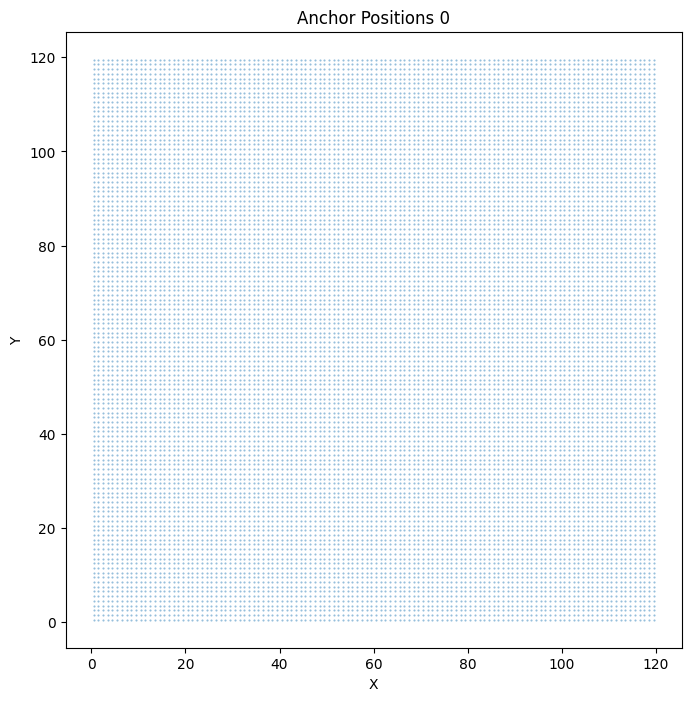

Embedding 1: torch.Size([1, 128, 60, 60])
Anchor 1: torch.Size([2, 3600])
Stride 1: torch.Size([1, 3600])


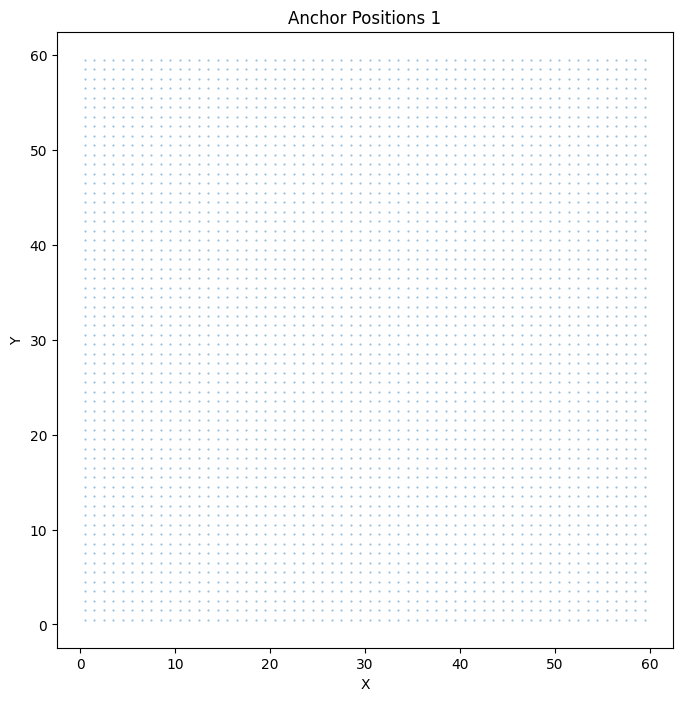

Embedding 2: torch.Size([1, 256, 30, 30])
Anchor 2: torch.Size([2, 900])
Stride 2: torch.Size([1, 900])


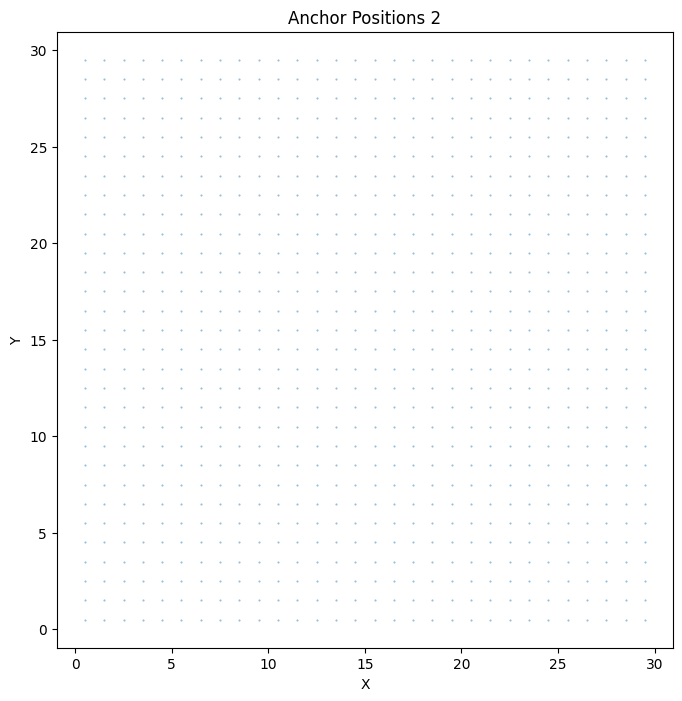

In [16]:
for i, emb in enumerate(embeddings):
    anchor, stride = [
        x.transpose(0, 1) for x in make_anchors([emb], head.stride[i : i + 1], 0.5)
    ]
    print(f"Embedding {i}: {emb.shape}")
    print(f"Anchor {i}: {anchor.shape}")
    print(f"Stride {i}: {stride.shape}")

    _, ax  = plt.subplots(figsize=(8, 8))
    ax.scatter(anchor[0].detach().cpu().numpy(), anchor[1].detach().cpu().numpy(), marker=".", alpha=0.5, s=1)
    ax.set(
        title=f"Anchor Positions {i}",
        xlabel="X",
        ylabel="Y",
        aspect="equal",
    )
    plt.show()

The first feature map has more anchors which can capture more granular detail of the input image, and the last feature map can handle courser looks.

## Which Feature Maps are Mostly Used?

Next, we will investigate **which feature maps contributes much** for the prediction of mortors.
To do this, we should apply another replace trick:

In [17]:
import torch


def new_forward(self, x):
    """
    MODIFICATION:
        - stop before _inference

    License: AGPL-3.0
    Source:
        - https://github.com/ultralytics/ultralytics
    """
    print("new forward")
    if self.end2end:
        x_detach = [xi.detach() for xi in x]
        one2one = [
            torch.cat(
                (self.one2one_cv2[i](x_detach[i]), self.one2one_cv3[i](x_detach[i])), 1
            )
            for i in range(self.nl)
        ]
        return dict(one2many=[], one2one=one2one)

    x_detach = [xi.detach() for xi in x]
    one2one = [
        torch.cat(
            (self.cv2[i](x_detach[i]), self.cv3[i](x_detach[i])), 1
        )
        for i in range(self.nl)
    ]
    return dict(one2many=[], one2one=one2one)


replace_method(head, "forward", new_forward)

In [18]:
import torch
from ultralytics.utils.tal import make_anchors


def new_inference(self, x):
    """
    MODIFICATION:
        - return the result of dfl head

    License: AGPL-3.0
    Source:
        - https://github.com/ultralytics/ultralytics
    """
    # Inference path
    shape = x[0].shape  # BCHW
    x_cat = torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2)

    if self.dynamic or shape != self.shape:
        self.anchors, self.strides = (
            x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5)
        )
        self.shape = shape
    box, cls = x_cat.split((self.reg_max * 4, self.nc), 1)
    dfl = self.dfl(box)
    dbox = self.decode_bboxes(dfl, self.anchors.unsqueeze(0), xywh=False) * self.strides

    return torch.cat((dbox, cls.sigmoid()), 1), dfl


replace_method(head, "_inference", new_inference)

### Visualize DFL Predictions of Each Feature Map

This replacement make YOLO returns the result of DFL predictions.
The **DFL** predicts how each edges of the bounding boxes are shifted from the center position of anchors.
They have four values `ltx, lty, rbx, rby` which corresponds with the `left, top, right, bottom` shifts respectively.

In [19]:
output = head(embeddings)
results, dfl = head._inference(output["one2one"])
print(results.shape)
print(dfl.shape)

new forward
torch.Size([1, 5, 18900])
torch.Size([1, 4, 18900])


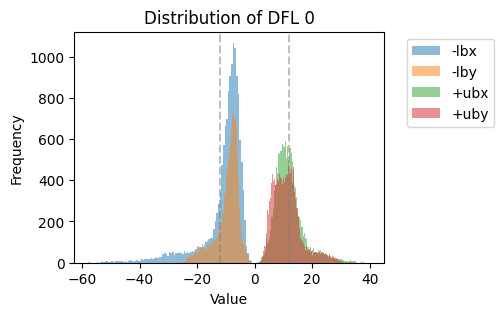

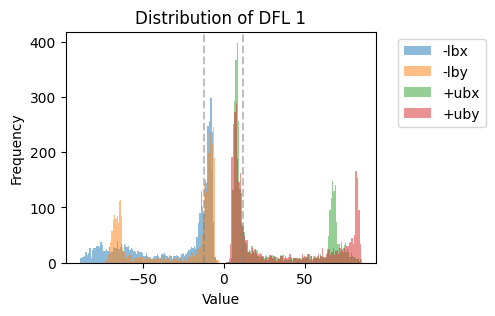

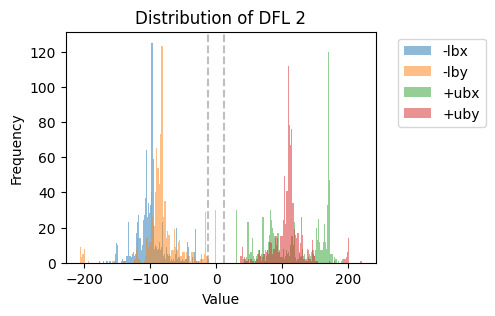

In [20]:
lt, rb = dfl.chunk(2, dim=1)
lt = lt[0].detach().cpu().numpy()
rb = rb[0].detach().cpu().numpy()
wh = rb + lt

offset = 0
for i, size in enumerate(anchor_sizes):
    li = offset
    ui = li + size
    offset += size
    s = head.stride[i].item()

    _, ax = plt.subplots(figsize=(4, 3))
    for label, value in zip(
        ["-lbx", "-lby", "+ubx", "+uby"],
        [-lt[0], -lt[1], rb[0], rb[1]],
    ):
        v = value[li:ui] * s

        ax.hist(v, label=f"{label}", bins=100, alpha=0.5)
    ax.set(
        title=f"Distribution of DFL {i}",
        xlabel="Value",
        ylabel="Frequency",
    )
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.axvline(-12, linestyle="--", color="gray", alpha=0.5, label="-12")
    ax.axvline(12, linestyle="--", color="gray", alpha=0.5, label="+12")
    plt.show()

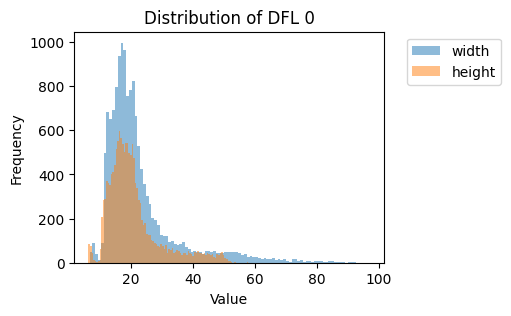

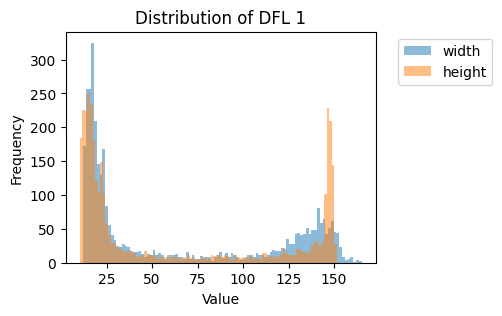

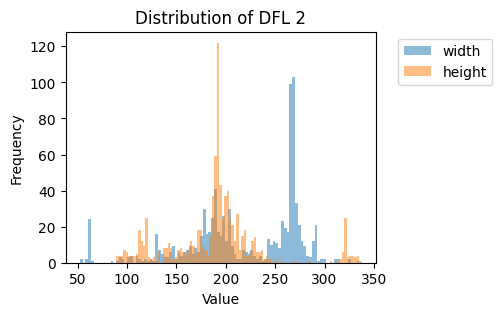

In [21]:
lt, rb = dfl.chunk(2, dim=1)
lt = lt[0].detach().cpu().numpy()
rb = rb[0].detach().cpu().numpy()
wh = rb + lt

offset = 0
for i, size in enumerate(anchor_sizes):
    li = offset
    ui = li + size
    offset += size
    s = head.stride[i].item()

    _, ax = plt.subplots(figsize=(4, 3))
    for label, value in zip(["width", "height"], [wh[0], wh[1]]):
        v = value[li:ui] * s

        ax.hist(v, label=f"{label}", bins=100, alpha=0.5)
    ax.set(
        title=f"Distribution of DFL {i}",
        xlabel="Value",
        ylabel="Frequency",
    )
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

Since the size of target bounding boxes are fixed at **24px**, we can see peaks around **20 pixels** in the predictions of first two feature maps.
On the other hand, we also see much larger peaks -- ~150px and ~200px respectively -- in the second and the third DFL predictions.
Maybe these are came from the feature of pre-trained datasets (e.g. MS-COCO), which contains larger bounding boxes.

Note that the DFL prediction of the last feature map doesn't have peaks at 12 pixels, **which indicates these feature map doesn't contribute much for the motor predictions**.

To see more clear evidence, let's look at the **confidence** of these anchors.

### Confidence Distribution of Each Feature Map

The below picture shows top-k distribution of confidence of each feature map.
As we anticipated, most of confident bounding boxes are came from the first and the second feature maps, and the third feature map has almost zero confidences. This indicates **the model rely more on the high-resolution feature maps to predict location of motors**.

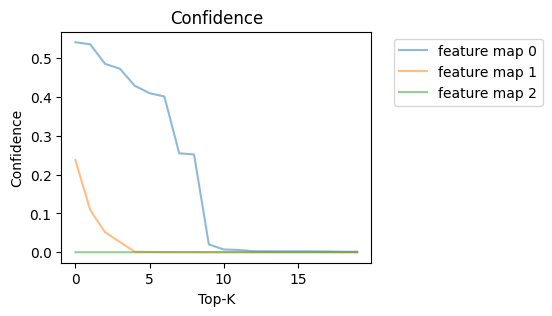

In [22]:
_, ax = plt.subplots(figsize=(4, 3))

offset = 0
for i, size in enumerate(anchor_sizes):
    li = offset
    ui = li + size
    offset += size

    conf = results[0, 4, li:ui].detach().cpu().numpy()
    sorted_conf = np.sort(conf)[::-1]

    ax.plot(
        sorted_conf[:20],
        label=f"feature map {i}",
        alpha=0.5,
    )
    ax.set(
        title="Confidence",
        xlabel="Top-K",
        ylabel="Confidence",
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## Final Result

The below picture shows the final result of YOLO's bounding box predictions.
As we can see, YOLO's prediction is highly "decisive" -- **they strongly concentrates on most confident few predictions rather than predicting various possible candidate boxes**. In other words, **they seems to weight precision more over recalls**. As such, it might struggle with tomogram which is very different from train dataset.

In [23]:
final_results = head.postprocess(results.permute(0, 2, 1), max_det=head.max_det, nc=head.nc)
print(final_results.shape)

torch.Size([1, 300, 6])


In [24]:
xyxys = final_results[0, :, :4].detach().cpu().numpy()
confs = final_results[0, :, 4].detach().cpu().numpy()

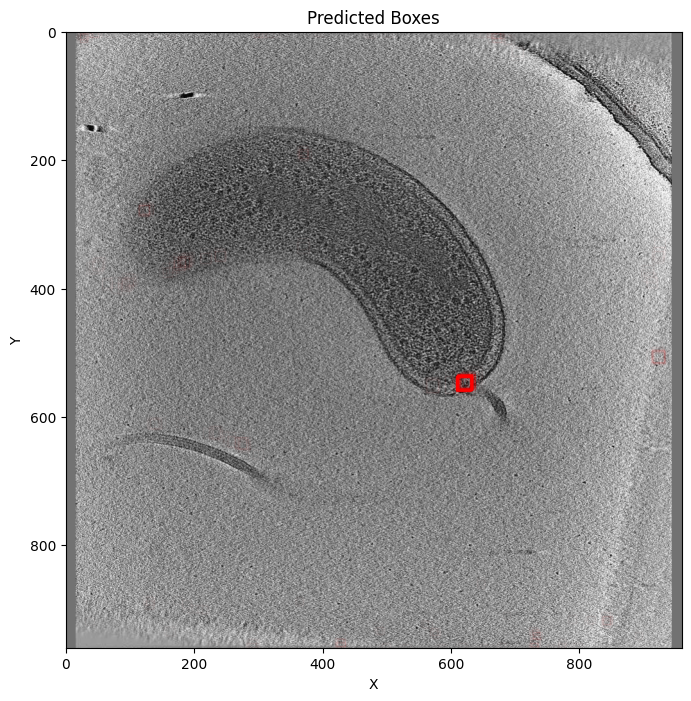

In [25]:
max_conf = confs.max()
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(transformed_img, cmap="gray")
for (x1, y1, x2, y2), c in zip(xyxys, confs):
    ax.add_patch(
        Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
            alpha=c**0.5 / max_conf**0.5,
        )
    )
ax.set(
    title="Predicted Boxes",
    xlabel="X",
    ylabel="Y",
    aspect="equal",
)
plt.show()

## Conclusion

In this notebook we investigated on the internal process of YOLO.

The key insights we can take from this notebook is:

* YOLO mostly relies on high-resolution fearture maps than lower ones
* YOLO seems to weights more on precision over recall